In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAexGothic')
plt.style.use("ggplot")
import japanize_matplotlib
from pydataset import data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA

In [2]:
# ========= データ読込 =========
cars = data('Cars93')  # 93行×多数列
# Rコードで指定した15変数のみ
cc = ["Min.Price","Price","Max.Price","MPG.city","MPG.highway",
      "EngineSize","Horsepower","RPM","Rev.per.mile","Fuel.tank.capacity",
      "Length","Wheelbase","Width","Turn.circle","Weight"]
df = cars[cc].astype(float)
make_labels = cars["Make"].astype(str).to_numpy()  # 93個の車種名（表示用）

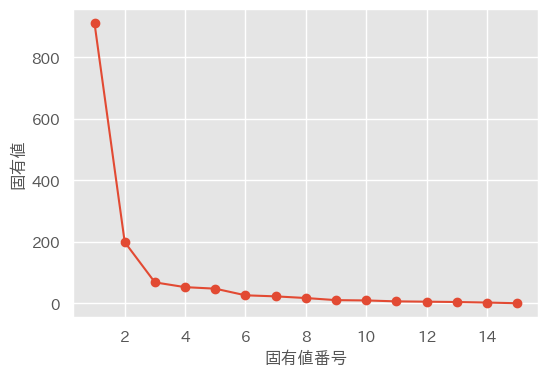

In [3]:
# ========= 実行例5.1: 標準化 → 転置 → 散布行列の固有値 =========
# R: Xc <- t(scale(Cars93[, mask]))
X = df.to_numpy(dtype=float)         # shape (93,15)
mu = X.mean(axis=0)                  # 列平均
sd = X.std(axis=0, ddof=1)           # 列標準偏差（分母 n-1）←ここがポイント！
n, d = X.shape
X_scaled = (X - mu) / sd             # Rの scale() と同じ
Xc = X_scaled.T                      # shape (15,93) ＝ t(scale(...))

# 散布行列 S = Xc %*% t(Xc)  (15×15)
S = Xc @ Xc.T
# 対称行列なので eigh を使用（昇順で返る）
eigvals, eigvecs = np.linalg.eigh(S)
# 降順(大きい順)に並べ替え
idx_desc = eigvals.argsort()[::-1]#インデックス
eigvals = eigvals[idx_desc]
eigvecs = eigvecs[:, idx_desc]

# 図: 固有値プロット
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(eigvals)+1), eigvals, marker="o")
plt.xlabel("固有値番号")
plt.ylabel("固有値")
#plt.title("Scatter matrix eigenvalues")
plt.show()

In [4]:
# ========= 実行例5.2: 正常部分空間(上位m)と異常度 a1 =========
m = 2
# R: x2 <- t(evd$vectors[,1:m]) %*% Xc
# （Pythonは eigvecs が降順に並んだので、そのまま先頭 m を使う）
V_top = eigvecs[:, :m]                # (15,m)
x2 = V_top.T @ Xc                     # (m,93)
a1 = (Xc**2).sum(axis=0) - (x2**2).sum(axis=0)  # (93,) サンプル毎の異常度
top6_idx = np.argsort(-a1)[:6]
print("=== 異常度 上位6 (a1) ===")
for i in top6_idx:
    print(f"{i+1:02d}: {make_labels[i]} -> {a1[i]:.4f}")

=== 異常度 上位6 (a1) ===
19: Chevrolet Corvette -> 13.5958
42: Honda Civic -> 11.8297
39: Geo Metro -> 11.1564
59: Mercedes-Benz 300E -> 10.5860
89: Volkswagen Eurovan -> 9.9711
28: Dodge Stealth -> 8.7273


In [5]:
# ========= 実行例5.3: グラム行列での計算（確認用に同等値） =========
# R: G <- t(Xc) %*% Xc （93×93）
G = Xc.T @ Xc
g_vals, g_vecs = np.linalg.eigh(G)  # 昇順
g_idx = g_vals.argsort()[::-1]
g_vals = g_vals[g_idx]
g_vecs = g_vecs[:, g_idx]           # (93,93) 降順

Lam_12 = np.diag(g_vals[:m]**(-0.5))     # (m,m)
# R: xx2 <- Lam_12 %*% t(evd$vectors[,1:m]) %*% t(Xc) %*% Xc
# ここで evd は G の固有分解に対応： g_vecs が evd$vectors
xx2 = Lam_12 @ g_vecs[:, :m].T @ Xc.T @ Xc   # (m,93)
aa1 = (Xc**2).sum(axis=0) - (xx2**2).sum(axis=0)
top3_idx = np.argsort(-aa1)[:3]
print("\n=== 異常度 上位3 (aa1, Gram 版) ===")
for i in top3_idx:
    print(f"{i+1:02d}: {make_labels[i]} -> {aa1[i]:.4f}")


=== 異常度 上位3 (aa1, Gram 版) ===
19: Chevrolet Corvette -> 13.5958
42: Honda Civic -> 11.8297
39: Geo Metro -> 11.1564


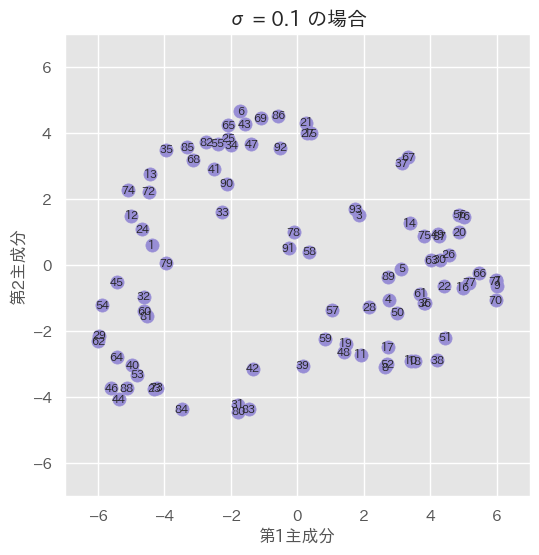

In [ ]:
# ========= 実行例5.4: カーネルPCA（RBF, sigma=sig） =========
m   = 2
sig = 0.1          # rbfdot(sigma=sig) に対応 → gamma = sig
li  = (-7, 7)      # 表示範囲

kpca = KernelPCA(
    n_components=m,
    kernel="rbf",
    gamma=sig,              # rbfdot(sigma=..) と対応
    fit_inverse_transform=False
)

# 1) 通常のカーネルPCAスコア（かなり -1〜1 に収まる）
Z_raw = kpca.fit_transform(X_scaled)          # shape (93,2)

# 2) 固有値を取得（新仕様名：eigenvalues_）
eigvals = kpca.eigenvalues_                  # shape (2,)

# 3) 各軸に sqrt(固有値) を掛けてスケール調整（Rのrotated()に近づける）
Zt = Z_raw * np.sqrt(eigvals)                # shape (93,2)

# Rの図はだいたい -6〜7 に収まっているので、そこに合わせる
max_abs = np.max(np.abs(Zt))
target_max = 6.0   # 好みで 6〜7 のどこか
scale_factor = target_max / max_abs

Zt = Zt * scale_factor

# ===== プロット =====
plt.figure(figsize=(6,6))
plt.scatter(Zt[:,0], Zt[:,1], s=90, c="C2")
# 車種番号（1..93）を重ね書き
for i in range(Zt.shape[0]):
    plt.text(Zt[i,0], Zt[i,1], str(i+1), fontsize=8, ha="center", va="center")
plt.xlim(li); plt.ylim(li)
plt.xlabel("第1主成分"); plt.ylabel("第2主成分")
plt.title(f"σ = {sig} の場合")
plt.show()

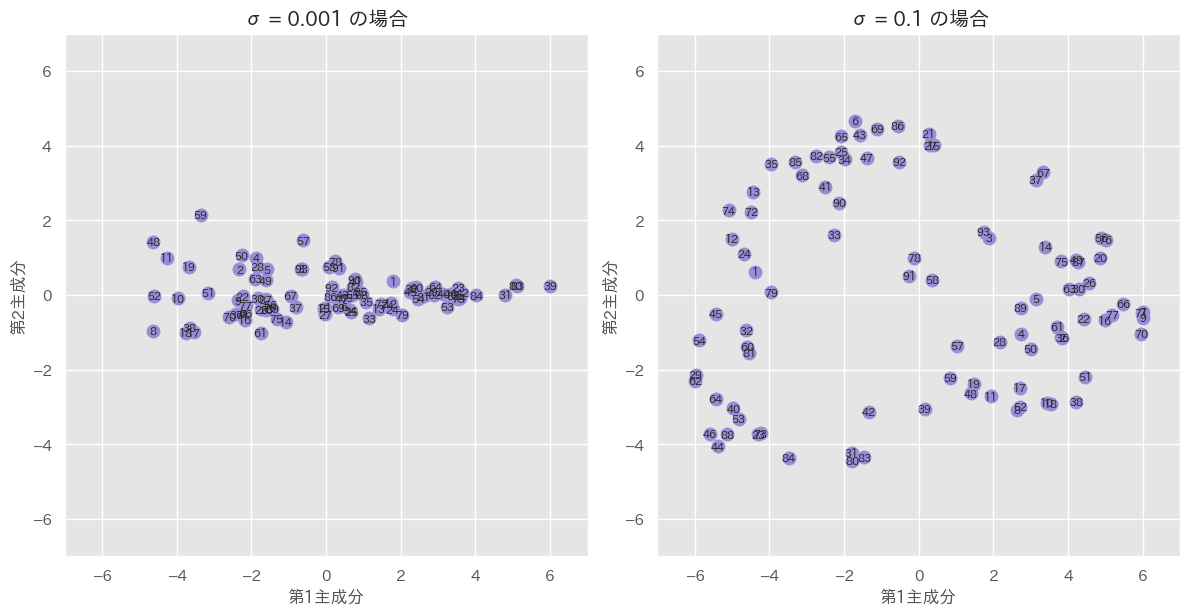

In [8]:
# ==== 実行例5.4：σ=0.001 と 0.1 を横に並べて描画 ====
m  = 2
li = (-7, 7)   # 表示範囲（両方そろえる）

sigmas = [0.001, 0.1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, sig in zip(axes, sigmas):
    kpca = KernelPCA(
        n_components=m,
        kernel="rbf",
        gamma=sig,               # rbfdot(sigma=sig) に対応
        fit_inverse_transform=False
    )

    # 1) 通常のカーネルPCAスコア（かなり -1〜1 に収まる）
    Z_raw = kpca.fit_transform(X_scaled)      # shape (93,2)

    # 2) 固有値を取得
    eigvals = kpca.eigenvalues_              # shape (2,)

    # 3) sqrt(固有値) を掛けてスケール調整（Rの rotated(kpc) に近づける）
    Zt = Z_raw * np.sqrt(eigvals)

    # 4) Rの図と同程度の広がりになるように定数倍で拡大
    max_abs = np.max(np.abs(Zt))
    target_max = 6.0           # お好みで 6〜7 程度
    scale_factor = target_max / max_abs
    Zt = Zt * scale_factor

    # ===== プロット =====
    ax.scatter(Zt[:, 0], Zt[:, 1], s=90, c="C2")
    for i in range(Zt.shape[0]):
        ax.text(Zt[i, 0], Zt[i, 1], str(i+1),
                fontsize=8, ha="center", va="center")

    ax.set_xlim(li)
    ax.set_ylim(li)
    ax.set_xlabel("第1主成分")
    ax.set_ylabel("第2主成分")
    ax.set_title(f"σ = {sig} の場合")
    ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()